# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [17]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from datetime import datetime
from pprint import pprint

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# If running code from previous CSV output (possible to avoid pinging API too many times), uncomment the second line.
run_api = True
run_api = False

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [18]:
#If running api, run below code. Otherwise, skip whole cell.
if run_api:

    # While loop ensures that the list of cities is always at least 500 unique cities. Defaults to true until code breaks.
    while True:
        # List for holding lat_lngs and cities
        lat_lngs = []
        cities = []

        # Create a set of random lat and lng combinations
        lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
        lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
        lat_lngs = zip(lats, lngs)

        # Identify nearest city for each lat, lng combination
        for lat_lng in lat_lngs:
            city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
            # If the city is unique, then add it to a our cities list
            if city not in cities:
                cities.append(city)

        # If statement confirms city count is sufficient, otherwise the loop is rerun.
        if len(cities) >= 500:
            print(f"There were {len(cities)} unique cities in the list.")
            break
        else:
            print(f"There were only {len(cities)} unique cities in the list. Rerunning list.")
        

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [19]:
#If running api, run below code. Otherwise, skip whole cell.
if run_api:

    # Perform API calls and print log of each city as calls are being made.

    # Set base url and initialize counting number.  Full url will follow that of the one below from API doc.
    #      api.openweathermap.org/data/2.5/weather?q={city name}&appid={your api key}
    base_url = "http://api.openweathermap.org/data/2.5/weather"
    counted_cities = 0

    # Initialize empty lists for relevant values.
    city_list = []
    lat_list = []
    lng_list = []
    max_temp_list = []
    humidity_list = []
    cloudiness_list = []
    wind_speed_list = []
    country_list = []
    date_list = []


    # Print for human eyes
    print("Beginning Data Retrieval")
    print("--------------------------------------")


    # for loop runs through all cities in cities array.

    for city in cities:

        # try ensures that even if city is not in database, the loop continues.
        # query_url is the url to grab data from api.  Response is where that data is stored.
        try:
            query_url = f"{base_url}?q={city}&appid={weather_api_key}"
            response = requests.get(query_url).json()
        
            # All list appends append relevant data to relevant list.
            city_list.append(response["name"])
            lat_list.append(response["coord"]["lat"])
            lng_list.append(response["coord"]["lon"])
            max_temp_list.append(response["main"]["temp_max"])
            humidity_list.append(response["main"]["humidity"])
            cloudiness_list.append(response["clouds"]["all"])
            wind_speed_list.append(response["wind"]["speed"])
            country_list.append(response["sys"]["country"])
            date_list.append(response["dt"])
        
            # Counted cities is a variable solely for the human that must waste as a guideline for how many cities remain.
            # Print the number of cities counted and the name of the city counted.
            counted_cities += 1
            print(f"Processing Record {counted_cities} | {city}")
    
        # If try fails, the except is triggered and the message states simply that the city is not found, then skips it.
        except:
            print(f"City not found.  Skipping the city {city}")

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [20]:
#If running api, run below code.
if run_api:
    
    # Converting arrays to a dataframe
    weather_df = pd.DataFrame({"City" : city_list,
                               "Latitude" : lat_list,
                               "Longitude" : lng_list,
                               "Maximum Temperature (\u00B0F)" : max_temp_list,
                               "Humidity (%)" : humidity_list,
                               "Cloudiness (%)" : cloudiness_list,
                               "Wind Speed (mph)" : wind_speed_list,
                               "Country" : country_list,
                               "Date" : date_list
                              }
                             )
    
    # Convert the temperature in Kelvin to degrees Farenheit.
    weather_df["Maximum Temperature (\u00B0F)"] = weather_df["Maximum Temperature (\u00B0F)"]*9/5-459.67
    
    # Exports dataframe to CSV file.
    weather_df.to_csv(output_data_file, index=False)

# If not running api, converts previous csv outout to weather dataframe.
else:
    weather_df = pd.read_csv(output_data_file)

In [21]:
# Outputs dataframe
weather_df.head()

,City,Latitude,Longitude,Maximum Temperature (°F),Humidity (%),Cloudiness (%),Wind Speed (mph),Country,Date
0,Narsaq,60.92,-46.05,60.800,38,16,3.10,GL,1970-01-01 00:00:01.595197418+00:00
1,Dikson,73.51,80.55,40.478,98,100,6.34,RU,1970-01-01 00:00:01.595197386+00:00
2,Ponoka,52.68,-113.58,64.004,87,75,2.10,CA,1970-01-01 00:00:01.595197516+00:00
3,Punta Arenas,-53.15,-70.92,35.600,69,75,3.10,CL,1970-01-01 00:00:01.595197243+00:00
4,Tasiilaq,65.61,-37.64,50.000,76,0,4.10,GL,1970-01-01 00:00:01.595197375+00:00


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [22]:
# Max humidity is checked.  If less than or equal to 100, the dataset is simply renamed.
if weather_df["Humidity (%)"].max()<=100:
    clean_city_data = weather_df

# If max humidity is greater than 100, then at least one humidity value is greater than 100.
else:
    #  Get the indices of cities that have humidity over 100%.
    too_humid_city_indices = weather_df.loc[weather_df["Humidity"] > 100].index.values.tolist()
    
    # Drop all indices that correspond with too high humidity to create a clean dataframe.
    clean_city_data = weather_df.drop(too_humid_city_indices)
    
    # Export the clean city data into a csv.
    clean_city_data.to_csv(output_data_file, index=False)      

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [32]:
# OPTIONAL: Create a function to create Linear Regression plots
# Because it further streamlines the code, I decided to also create a function for the scatter plots.

# A function that creates the scatter plots.
def make_scatter_plots(x_values, y_values, hemisphere):
    
    # Ensures the correct dataframe is being used.
    if hemisphere == "both":
        df = clean_city_data
    elif hemisphere == "Northern":
        df = northern_city_clean_df
    else:
        df = southern_city_clean_df
    
    # Extracts the x and y values to be examined from the clean city dataframe.
    x = df[x_values]
    y = df[y_values]

    # Labels, titles, and scatter plot is made.
    plt.xlabel(x_values)
    plt.ylabel(y_values)
    plt.title(f"{x_values} by {y_values} on ({datetime.today().strftime('%Y/%m/%d')})")
    plt.scatter(x,y)

# A function that runs the linear regression.
def lin_regress(x_values, y_values, hemisphere):
    
    # Creates the scatter plot onto which the linear regression will be mapped.
    make_scatter_plots(x_values, y_values, hemisphere)

    # Ensures the correct dataframe is being used.
    if hemisphere == "both":
        df = clean_city_data
    elif hemisphere == "Northern":
        df = northern_city_clean_df
    else:
        df = southern_city_clean_df
    
    # Extracts the x and y values to be examined from the dataframe remembered from running scatter plot.
    x = df[x_values]
    y = df[y_values]
    
    # Run linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    plt.plot(x, intercept + slope*x, 'r')
    r_out = r_value.round(decimals=2)
    
    # Change plot title
    plt.title(f"{x_values} by {y_values} in {hemisphere} hemisphere on ({datetime.today().strftime('%Y/%m/%d')})")
    
    return(f"The Pearson correlation coefficient for the above linear regression is {r_out}")

## Latitude vs. Temperature Plot

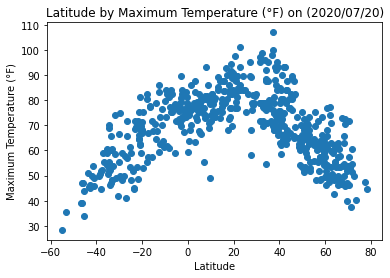

This code tracks the maximum temperature measured in a day at over 500 random locations, and the location's 
latitude. The above chart shows that temperature increases until some latitude is reached, at which point the 
temperature drops with a change in latitude.  This is consistent with the Earth as a sphere floating in space 
recieving energy from the sun.


In [24]:
# The values being compared are saved as the string titles of the relevant columns of the dataframe so only 2 substitutions 
#    need to be made for any given graph.
x_values = "Latitude"
y_values = "Maximum Temperature (\u00B0F)"
hemisphere = "both"

# Makes scatter plot using function.
make_scatter_plots(x_values, y_values, hemisphere)


# Analysis is written
analysis = "This code tracks the maximum temperature measured in a day at over 500 random locations, and the location's \n"
analysis += "latitude. The above chart shows that temperature increases until some latitude is reached, at which point the \n"
analysis += "temperature drops with a change in latitude.  This is consistent with the Earth as a sphere floating in space \n"
analysis += "recieving energy from the sun."

# All outputs are output.
plt.show()
print(analysis)


## Latitude vs. Humidity Plot

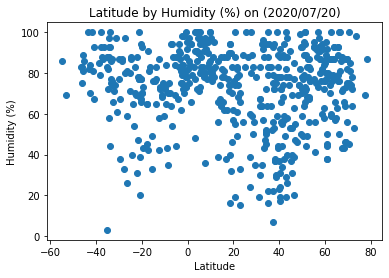

This code tracks the humidity measured in a day at over 500 random locations, and the location's latitude. 
Note that the humidity tends to be quite high regardless of the altitude.  This is probably selection bias, 
as the code tracks by cities and most people will build near a source of water, leading to higher humidity 
at measured locations.


In [25]:
# The values being compared are saved as the string titles of the relevant columns of the dataframe so only 2 substitutions 
#    need to be made for any given graph.
x_values = "Latitude"
y_values = "Humidity (%)"
hemisphere = "both"

# Makes scatter plot using function.
make_scatter_plots(x_values, y_values, hemisphere)

# Analysis is written
analysis = "This code tracks the humidity measured in a day at over 500 random locations, and the location's latitude. \n"
analysis += "Note that the humidity tends to be quite high regardless of the altitude.  This is probably selection bias, \n"
analysis += "as the code tracks by cities and most people will build near a source of water, leading to higher humidity \n"
analysis += "at measured locations."

# All outputs are output.
plt.show()
print(analysis)

## Latitude vs. Cloudiness Plot

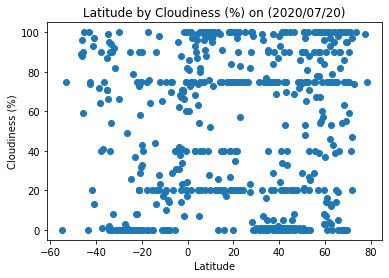

This code tracks the cloudiness as a percentage measured in a day at over 500 random locations, and the 
location's latitude. This data is fairly random, and not much of value can be gotten from this particular graph.


In [26]:
# The values being compared are saved as the string titles of the relevant columns of the dataframe so only 2 substitutions 
#    need to be made for any given graph.
x_values = "Latitude"
y_values = "Cloudiness (%)"
hemisphere = "both"

# Makes scatter plot using function.
make_scatter_plots(x_values, y_values, hemisphere)


# Analysis is written
analysis = "This code tracks the cloudiness as a percentage measured in a day at over 500 random locations, and the \n"
analysis += "location's latitude. This data is fairly random, and not much of value can be gotten from this particular graph."  


# All outputs are output.
plt.show()
print(analysis)

## Latitude vs. Wind Speed Plot

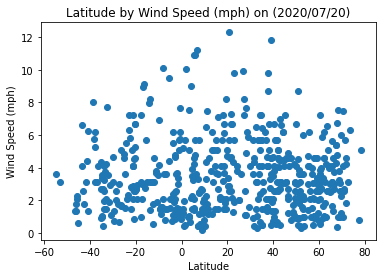

This code tracks the wind speed measured in a day at over 500 random locations, and the location's latitude. 
Note that the highest wind speeds are measured highest near the same latitude as the highest temperature. 
As temperature gradients cause pressure waves which we feel as wind, this is not a surprise.  The hottest 
places may well have the most energetic wind to push elsewhere.


In [27]:
# The values being compared are saved as the string titles of the relevant columns of the dataframe so only 2 substitutions 
#    need to be made for any given graph.
x_values = "Latitude"
y_values = "Wind Speed (mph)"
hemisphere = "both"

# Makes scatter plot using function.
make_scatter_plots(x_values, y_values, hemisphere)

# Analysis is written
analysis = "This code tracks the wind speed measured in a day at over 500 random locations, and the location's latitude. \n"
analysis += "Note that the highest wind speeds are measured highest near the same latitude as the highest temperature. \n"
analysis += "As temperature gradients cause pressure waves which we feel as wind, this is not a surprise.  The hottest \n"
analysis += "places may well have the most energetic wind to push elsewhere."


# All outputs are output.
plt.show()
print(analysis)

## Linear Regression

In [28]:
# Create Northern and Southern Hemisphere DataFrames
northern_city_clean_df = clean_city_data.loc[clean_city_data["Latitude"] >= 0]
southern_city_clean_df = clean_city_data.loc[clean_city_data["Latitude"] < 0]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression